### LSTM for multivariate, multistep forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras import metrics



Using TensorFlow backend.
/Users/alket/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/alket/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/alket/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/alket/anaconda3/lib/python3.7/site-packages/tenso

### Load data

In [2]:
data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)
#data = pd.read_csv('/Users/alket/Desktop/dati/new_data_Modena_backfill_forwfill.csv',index_col = 0)
# aggregazione dati per celle
agg_by_cell = data.groupby(by = ['cell_num'])

In [3]:
num_data = []
## prepare dataset
for i, k in agg_by_cell:
    cell_i = agg_by_cell.get_group(i)
    # define input sequence
    series_i = cell_i['nr_people'].values
    series_i = series_i.reshape((len(series_i), 1))
    num_data.append(series_i)

In [4]:
final_data = hstack((num_data))
final_data.shape

(11808, 221)

### Prepare input data for LSTM model 

In [5]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
    
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
# length of input should be equal to length of output otherwise learning becomes instable
n_steps_in, n_steps_out = 20, 20

# covert into input/output
X, y = split_sequences(final_data, n_steps_in, n_steps_out)
count = 0
for i in range(len(X)):
    count += 1
    print(X[i], y[i]) 
    if count > 1: break
    

[[ 36.  39.  41. ...  17. 104.  35.]
 [ 36.  38.  40. ...  17. 106.  36.]
 [ 34.  36.  38. ...  17. 107.  36.]
 ...
 [ 21.  22.  22. ...  17. 102.  34.]
 [ 20.  21.  22. ...  17. 103.  34.]
 [ 20.  20.  21. ...  17. 102.  34.]] [[ 19.  20.  20. ...  17. 103.  34.]
 [ 19.  19.  20. ...  17. 104.  35.]
 [ 18.  19.  19. ...  17. 103.  34.]
 ...
 [ 23.  24.  25. ...  16.  97.  32.]
 [ 23.  24.  25. ...  16.  97.  32.]
 [ 27.  29.  30. ...  18. 102.  34.]]
[[ 36.  38.  40. ...  17. 106.  36.]
 [ 34.  36.  38. ...  17. 107.  36.]
 [ 33.  35.  37. ...  17. 106.  35.]
 ...
 [ 20.  21.  22. ...  17. 103.  34.]
 [ 20.  20.  21. ...  17. 102.  34.]
 [ 19.  20.  20. ...  17. 103.  34.]] [[ 19.  19.  20. ...  17. 104.  35.]
 [ 18.  19.  19. ...  17. 103.  34.]
 [ 18.  18.  19. ...  17. 102.  34.]
 ...
 [ 23.  24.  25. ...  16.  97.  32.]
 [ 27.  29.  30. ...  18. 102.  34.]
 [ 27.  29.  31. ...  17.  99.  33.]]


### Prepare train-test set

In [6]:
split_train_test = int(len(X)*0.75)
train_X, test_X = X[:split_train_test], X[split_train_test:]
train_y, test_y = y[:split_train_test], y[split_train_test:]
print(len(train_X), len(train_y), len(test_X), len(test_y))

8826 8826 2943 2943


### Define LSTM model

In [15]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features))) 
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True)) 
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse',  metrics=[metrics.mae, 'accuracy'])

# fit model
#model.fit(train_X, train_y, epochs=15, verbose=2)
history = model.fit(train_X, train_y, validation_split=0.33, epochs=10, verbose=1) 

Train on 5913 samples, validate on 2913 samples
Epoch 1/10
5913/5913 [==============================] - 12s 2ms/step - loss: 717433.8791 - mean_absolute_error: 486.4890 - accuracy: 0.2418 - val_loss: 25978.7155 - val_mean_absolute_error: 117.6589 - val_accuracy: 0.4836
Epoch 2/10
5913/5913 [==============================] - 12s 2ms/step - loss: 14747.3421 - mean_absolute_error: 84.0586 - accuracy: 0.6992 - val_loss: 9608.1263 - val_mean_absolute_error: 68.7709 - val_accuracy: 0.4533
Epoch 3/10
5913/5913 [==============================] - 12s 2ms/step - loss: 8031.0799 - mean_absolute_error: 60.0397 - accuracy: 0.7496 - val_loss: 6891.0541 - val_mean_absolute_error: 56.1446 - val_accuracy: 0.4654
Epoch 4/10
5913/5913 [==============================] - 12s 2ms/step - loss: 6675.4413 - mean_absolute_error: 52.8534 - accuracy: 0.7887 - val_loss: 6647.5072 - val_mean_absolute_error: 53.7509 - val_accuracy: 0.4462
Epoch 5/10
5913/5913 [==============================] - 13s 2ms/step - loss: 5

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_accuracy', 'loss', 'mean_absolute_error', 'accuracy'])


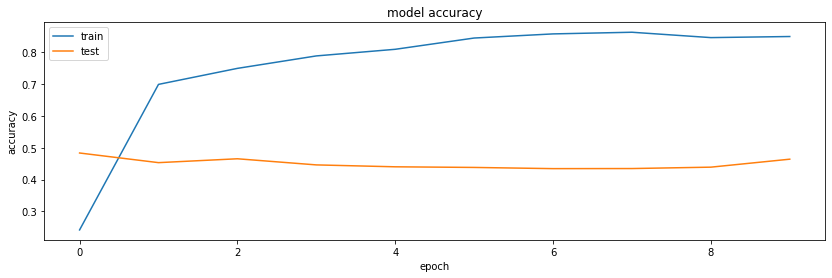

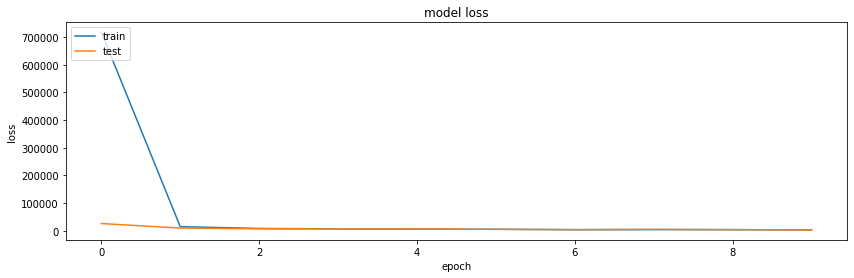

In [16]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.figure(figsize = (14, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

# summarize history for loss
plt.figure(figsize = (14, 4))
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [17]:
# predict and compute error
predicted = np.array([])

for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0]) 


expected = test_y

expected = np.reshape(expected, expected.shape[0] * expected.shape[1]* expected.shape[2])

Mean Absolute Error =  33.00794023668252


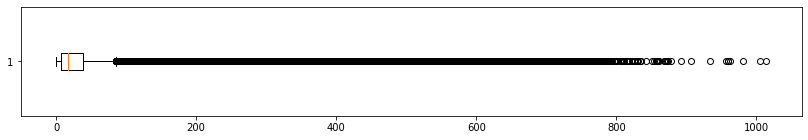

In [18]:
# abs difference
difference = abs((expected - predicted))
print('Mean Absolute Error = ', np.mean(difference))


# show boxplot
plt.figure(figsize = (14,2))
plt.boxplot(difference, vert= False);
plt.show()